03_finetuning_resnet.ipynb
- Load dataloaders
- Load ResNet
- Train loop
- Validation loop
- Save best model
- Test accuracy & metrics


In [6]:
import pandas as pd

train_df = pd.read_csv("CSV/plantvillage_train.csv")
val_df   = pd.read_csv("CSV/plantvillage_val.csv")
test_df  = pd.read_csv("CSV/plantvillage_test.csv")

print("Train label counts:")
print(train_df["label"].value_counts())
print("\nValidation label counts:")
print(val_df["label"].value_counts())
print("\nTest label counts:")
print(test_df["label"].value_counts())


Train label counts:
label
0    1777
1    1582
Name: count, dtype: int64

Validation label counts:
label
0    381
1    339
Name: count, dtype: int64

Test label counts:
label
0    381
1    339
Name: count, dtype: int64


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load pretrained model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# 2. Replace final layer (fc) to output 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

# 3. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [2]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchvision.transforms as T

class PlantBinaryDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["image_path"]
        label = int(row["label"])

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# same transforms as notebook 02
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

# load datasets
train_dataset = PlantBinaryDataset("CSV/plantvillage_train.csv", transform=train_transform)
val_dataset   = PlantBinaryDataset("CSV/plantvillage_val.csv",   transform=val_transform)
test_dataset  = PlantBinaryDataset("CSV/plantvillage_test.csv",  transform=val_transform)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=0)



In [3]:
import time
import copy
import torch

num_epochs = 10  # you can adjust

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10, device="cpu"):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)          # shape [batch_size, 2]
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                running_corrects += torch.sum(preds == labels).item()
                total_samples += batch_size

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects / total_samples

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # deep copy the model if validation improves
            if phase == "val" and epoch_acc > best_val_acc:
                best_val_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed/60:.1f} min")
    print(f"Best val Acc: {best_val_acc:.4f}")

    # load best weights
    model.load_state_dict(best_model_wts)
    return model

# actually train
model = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs=num_epochs,
    device=device,
)


Epoch 1/10
--------------------
train Loss: 0.0670 Acc: 0.9741
val Loss: 0.0069 Acc: 0.9972

Epoch 2/10
--------------------
train Loss: 0.0085 Acc: 0.9979
val Loss: 0.0023 Acc: 1.0000

Epoch 3/10
--------------------
train Loss: 0.0057 Acc: 0.9985
val Loss: 0.0036 Acc: 0.9986

Epoch 4/10
--------------------
train Loss: 0.0042 Acc: 0.9985
val Loss: 0.0031 Acc: 0.9986

Epoch 5/10
--------------------
train Loss: 0.0038 Acc: 0.9991
val Loss: 0.0048 Acc: 0.9972

Epoch 6/10
--------------------
train Loss: 0.0018 Acc: 1.0000
val Loss: 0.0005 Acc: 1.0000

Epoch 7/10
--------------------
train Loss: 0.0014 Acc: 0.9997
val Loss: 0.0006 Acc: 1.0000

Epoch 8/10
--------------------
train Loss: 0.0023 Acc: 0.9994
val Loss: 0.0003 Acc: 1.0000

Epoch 9/10
--------------------
train Loss: 0.0030 Acc: 0.9994
val Loss: 0.0008 Acc: 1.0000

Epoch 10/10
--------------------
train Loss: 0.0052 Acc: 0.9982
val Loss: 0.0008 Acc: 1.0000

Training complete in 30.6 min
Best val Acc: 1.0000


In [4]:
def evaluate_on_test(model, test_loader, device="cpu"):
    model.eval()
    running_corrects = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels).item()
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    test_acc = running_corrects / total_samples
    print(f"Test accuracy: {test_acc:.4f}")

    return all_labels, all_preds

labels, preds = evaluate_on_test(model, test_loader, device=device)


Test accuracy: 1.0000


In [7]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(labels, preds)
print("Confusion matrix:\n", cm)

print("\nClassification report:\n")
print(classification_report(labels, preds, digits=4))


Confusion matrix:
 [[381   0]
 [  0 339]]

Classification report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       381
           1     1.0000    1.0000    1.0000       339

    accuracy                         1.0000       720
   macro avg     1.0000    1.0000    1.0000       720
weighted avg     1.0000    1.0000    1.0000       720



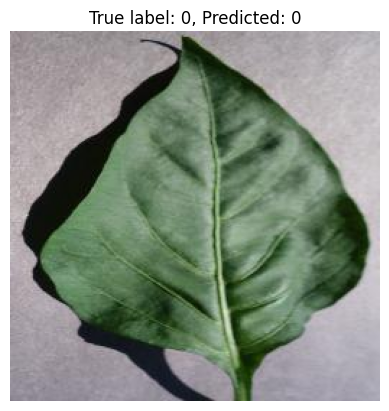

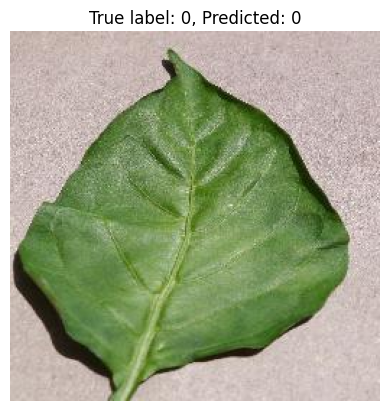

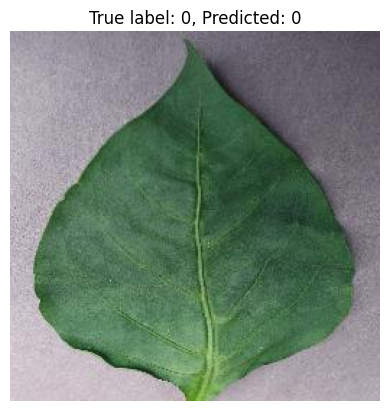

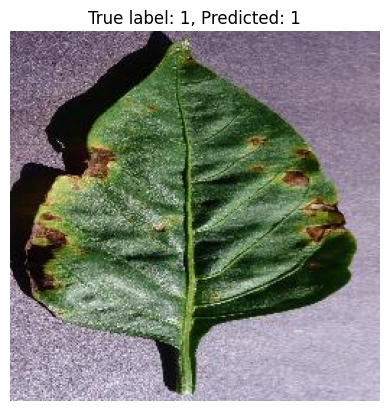

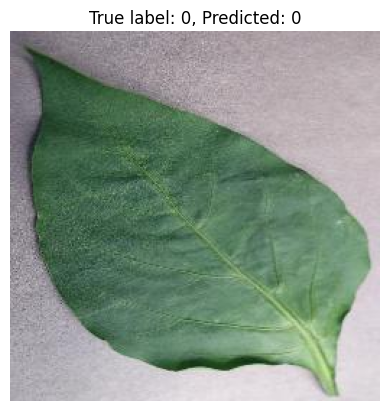

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

test_df = pd.read_csv("CSV/plantvillage_test.csv")

for _ in range(5):
    row = test_df.sample(1).iloc[0]
    img = Image.open(row["image_path"]).convert("RGB")

    x = val_transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x)
        pred = out.argmax(dim=1).item()

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"True label: {row['label']}, Predicted: {pred}")
    plt.show()
